In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

!pip install deepface

import io # Input/Output Module
import os # OS interfaces
import cv2 # OpenCV package
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import statistics
import warnings

from urllib import request # module for opening HTTP requests
from matplotlib import pyplot as plt # Plotting library

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns
import statistics
from sklearn.manifold import TSNE

import sklearn
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier


from deepface import DeepFace
from operator import itemgetter
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 1
---------------------------------------------------------------
Student numbers: <span style="color:red">r1, r0927846, r0928210, r0928016, r0922060</span>.

The goal of this assignment is to explore more advanced techniques for constructing features that better describe objects of interest and to perform face recognition using these features. This assignment will be delivered in groups of 5 (either composed by you or randomly assigned by your TA's).

In this assignment you are a group of computer vision experts that have been invited to ECCV 2021 to do a tutorial about  "Feature representations, then and now". To prepare the tutorial you are asked to participate in a kaggle competition and to release a notebook that can be easily studied by the tutorial participants. Your target audience is: (master) students who want to get a first hands-on introduction to the techniques that you apply.

---------------------------------------------------------------
This notebook is structured as follows:
0. Data loading & Preprocessing
1. Feature Representations
2. Evaluation Metrics 
3. Classifiers
4. Experiments
5. Publishing best results
6. Discussion

Make sure that your notebook is **self-contained** and **fully documented**. Walk us through all steps of your code. Treat your notebook as a tutorial for students who need to get a first hands-on introduction to the techniques that you apply. Provide strong arguments for the design choices that you made and what insights you got from your experiments. Make use of the *Group assignment* forum/discussion board on Toledo if you have any questions.

Fill in your student numbers above and get to it! Good luck! 
    
---------------------------------------------------------------
# 0. Data loading & Preprocessing

## 0.1. Loading data
The training set is many times smaller than the test set and this might strike you as odd, however, this is close to a real world scenario where your system might be put through daily use! In this session we will try to do the best we can with the data that we've got! 

In [2]:
# Input data files are available in the read-only "../input/" directory

train = pd.read_csv(
    '/kaggle/input/kul-h02a5a-computer-vision-ga1-2023/train_set.csv', index_col = 0)
train.index = train.index.rename('id')

test = pd.read_csv(
    '/kaggle/input/kul-h02a5a-computer-vision-ga1-2023/test_set.csv', index_col = 0)
test.index = test.index.rename('id')

# read the images as numpy arrays and store in "img" column
train['img'] = [cv2.cvtColor(np.load('/kaggle/input/kul-h02a5a-computer-vision-ga1-2023/train/train_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in train.iterrows()]

test['img'] = [cv2.cvtColor(np.load('/kaggle/input/kul-h02a5a-computer-vision-ga1-2023/test/test_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in test.iterrows()]
  

train_size, test_size = len(train),len(test)

"The training set contains {} examples, the test set contains {} examples.".format(train_size, test_size)

'The training set contains 80 examples, the test set contains 1816 examples.'

*Note: this dataset is a subset of the* [*VGG face dataset*](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/).

## 0.2. A first look
Let's have a look at the data columns and class distribution.

In [3]:
# The training set contains an identifier, name, image information and class label
train.head(1)

,name,class,img
id,,,
0,Mila_Kunis,2,"[[[50, 31, 25], [49, 30, 24], [49, 30, 24], [4..."


In [4]:
# The test set only contains an identifier and corresponding image information.

test.head(1)

,img
id,
0,"[[[209, 210, 205], [208, 209, 204], [208, 209,..."


In [5]:
# The class distribution in the training set:
train.groupby('name').agg({'img':'count', 'class': 'max'})

,img,class
name,,
Jesse_Eisenberg,30,1
Michael_Cera,10,0
Mila_Kunis,30,2
Sarah_Hyland,10,0


Note that **Jesse is assigned the classification label 1**, and **Mila is assigned the classification label 2**. The dataset also contains 20 images of **look alikes (assigned classification label 0)** and the raw images. 

## 0.3. Preprocess data with DeepFacePreprocessor

Some discussion abt why this is better for us compared to HAAR




In [4]:
class DeepFacePreprocessor():
    """Preprocessing pipeline built around DeepFace face detector. """
    
    def __init__(self, backend, face_size):
        self.face_size = face_size
        self.backend = backend
            
    def detect_faces(self, img, backend):
        """Detect all faces in an image."""
        return DeepFace.extract_faces(img, detector_backend = backend, enforce_detection=False, align=False, target_size=self.face_size)
        
    def extract_faces(self, img):
        """Returns 3 most probable faces (cropped) in an image."""
        
        faces = self.detect_faces(img, self.backend)
        faces.sort(key=itemgetter('confidence'), reverse=True)
        # If no faces found, try again with a better backend
        if faces[0]['confidence'] == 0:
            faces = self.detect_faces(img, "retinaface")

        # If still no faces found, return empty list
        if faces[0]['confidence'] == 0:
            return []
        
        #select 3 best matches
        faces = faces[:3]
        #normalize faces
        faces_normalized = [cv2.normalize(face['face'], None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8) for face in faces]
        return [cv2.cvtColor(face, cv2.COLOR_BGR2RGB) for face in faces_normalized]
    
    def preprocess(self, data_row, i, manual_choices=None):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        elif len(faces) != 1 and manual_choices is not None and i in manual_choices:
            #if we detect more than 1 face we can select correct one manually
            return faces[manual_choices[i]]
        
        # if we didn't specify a face to choose manualy return the first one
        return faces[0]
        
    def __call__(self, data, manual_choices=None):
        return np.stack([self.preprocess(row, i, manual_choices) for i, row in data.iterrows()]).astype(int)

**Visualise**

Let's plot a few examples.

Mention why we hand pick some labels


In [ ]:
# # parameter to play with 
# FACE_SIZE = (150, 150)

# def plot_image_sequence(data, n, imgs_per_row=7):
#     n_rows = 1 + int(n/(imgs_per_row+1))
#     n_cols = min(imgs_per_row, n)

#     f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))
#     for i in range(n):
#         if n == 1:
#             ax.imshow(data[i])
#         elif n_rows > 1:
#             ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(data[i])
#         else:
#             ax[int(i%n)].imshow(data[i])
#     plt.show()

    
# #preprocessed data 
# # preprocessor = HAARPreprocessor(path = '../../tmp', face_size=FACE_SIZE)

# # train_X, train_y = preprocessor(train), train['class'].values
# # test_X = preprocessor(test)

# # we are using DeepFacePreprocessor since it has a better performance
# # if data hasn't been preprocessed yet
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     preprocessor = DeepFacePreprocessor("ssd", FACE_SIZE)
    
#     manual_choices = {0: 0, 9: 0, 18: 1, 26: 0, 30: 0, 32: 0, 34: 2, 41: 0, 49:1, 50:0, 52:1, 53:1, 57:0, 59:1, 61:0, 70:0, 73:0, 77:0}
#     train_X, train_y = preprocessor(train, manual_choices), train['class'].values
#     test_X = preprocessor(test)
    
#     # Filtering imgs that are not faces ONCE
#     a = train_y[train_y == 2]
#     np.put(a, [24], 0)
#     train_y[train_y == 2] = a


In [ ]:
# # plot faces of Michael and Sarah

# plot_image_sequence(train_X[train_y == 0], n=len(train_X[train_y == 0]), imgs_per_row=10)

In [ ]:
# # plot faces of Jesse
# # 6, 12?, 15, 18, 27



# plot_image_sequence(train_X[train_y == 1], n=len(train_X[train_y == 1]), imgs_per_row=10)

In [ ]:
# # plot faces of Mila
# # 5?, 7?, 15, 24

# plot_image_sequence(train_X[train_y == 2], n=len(train_X[train_y == 2]), imgs_per_row=10)

In [187]:
# a = train_y[train_y == 1]
# for i in [6, 12, 15, 18, 27]:
#     np.put(a, i, 0)
# train_y[train_y == 1] = a

# a = train_y[train_y == 2]
# for i in [5, 7, 15, 23, 24]:
#     np.put(a, i, 0)
# train_y[train_y == 2] = a

Now we are ready to rock!

The code below saves the pre-processed data onto the current session. 

In [47]:
# # save preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
    
# np.save(os.path.join(prep_path, 'train_X.npy'), train_X)
# np.save(os.path.join(prep_path, 'train_y.npy'), train_y)
# np.save(os.path.join(prep_path, 'test_X.npy'), test_X)

If you already have pre-processed images, you can uncomment the code below and use them.

In [3]:
# prep_path = '/kaggle/input/cv-ga1-dataset/'
# train_X = np.load(os.path.join(prep_path, 'train_X.npy'))
# train_y = np.load(os.path.join(prep_path, 'train_y.npy'))
# test_X = np.load(os.path.join(prep_path, 'test_X.npy'))

# 1. Feature Representations
## 1.0. Example: Identify feature extractor
Our example feature extractor doesn't actually do anything... It just returns the input:
$$
\forall x : f(x) = x.
$$

It does make for a good placeholder and baseclass ;).

In [7]:
class IdentityFeatureExtractor:
    """A simple function that returns the input"""
    
    def transform(self, X):
        return X
    
    def __call__(self, X):
        return self.transform(X)

## 1.1. Baseline 1: Scale Invariant Feature Transform
...

In [163]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
        
class SIFTFeatureExtractor(IdentityFeatureExtractor):
    
    def __init__(self, **params):
        self.params = params
        self.sift = cv2.SIFT_create(
                            nfeatures =  self.params.get('nfeatures'),
                            nOctaveLayers = self.params.get('nOctaveLayers'),
                            contrastThreshold = self.params.get('contrastThreshold'),
                            edgeThreshold = self.params.get('edgeThreshold'),
                            sigma = self.params.get('sigma') )
        
    def transform(self, X):        
        images_descriptors = []
        for img in X:
            gray = cv2.cvtColor(img.astype(dtype=np.uint8), cv2.COLOR_BGR2GRAY)
            _, descriptors = self.sift.detectAndCompute(gray, None)
            images_descriptors.append(descriptors)
        return np.asarray(images_descriptors)
    
    def flatten(self,image_descriptors):
        # Filter Nones and flattens array to kx128 dimension
        all_descriptors = []
        for descriptors_per_img in image_descriptors:
            if descriptors_per_img is not None:
                for e in descriptors_per_img:
                    all_descriptors.append(e)
        return all_descriptors
    
    def compare_two_img(self, img1, img2):
        img1 = img1.astype(dtype=np.uint8)
        img2 = img2.astype(dtype=np.uint8)
        gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck = True)
        
        keypoints1, descriptors1 = self.sift.detectAndCompute(gray1, None)
        keypoints2, descriptors2 = self.sift.detectAndCompute(gray2, None) 
        
        if descriptors1 is None: 
            return print('Cannot proceed. Img1 has descriptors: None')
        if descriptors2 is None:
            return print('Cannot proceed. Img2 has descriptors: None')

        matches = bf.match(descriptors1,descriptors2)
        matches = sorted(matches, key = lambda x:x.distance)

        img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches, outImg = np.empty((1,1)))
        plt.imshow(img_matches)
    
    
    def __call__(self, X):
        return self.transform(X)
    
    

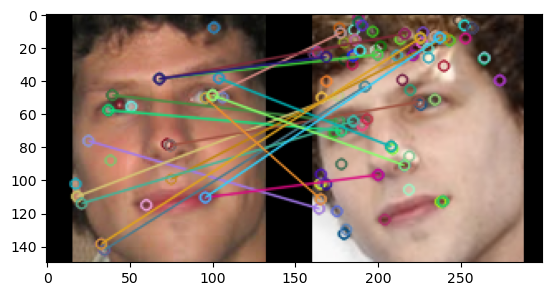

In [166]:
#Create a SIFT extractor with choosen Hyperameters
# sift_extractor = SIFTFeatureExtractor() 
sift_extractor = SIFTFeatureExtractor(
                            nOctaveLayers = 10,
                            contrastThreshold = 0.07,
                            edgeThreshold = 10,
                            sigma = 1.6)

# Plot the matches between two faces
sift_extractor.compare_two_img(train_X[12], train_X[17])

### 1.1.1. t-SNE Plots
...

In [168]:
# Defining TSNE with same seed for reproducibility
seed = 42
tsne = TSNE(random_state = seed, perplexity=15) 

# Colours for scatterplot 
palette = sns.color_palette("bright", 3)

# Function for creating a matrix with similarity-based distances between each image
def get_distance_matrix(images_descriptors):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck = True)
    features = []
    for (i, descriptors1) in enumerate(images_descriptors):
        features.append([])
        for (j, descriptors2) in enumerate(images_descriptors):
            if i == j:
                distance = 0
            elif descriptors1 is None or descriptors2 is None:
                distance = 999
            else:
                matches = bf.match(descriptors1, descriptors2)
                distance = statistics.mean([match.distance for match in matches])

            features[i].append(distance)
    return features

In [169]:
# Defines SIFT extractor with specific hyperparameters
sift_extractor = SIFTFeatureExtractor(
                            nfeatures= None,
                            nOctaveLayers = 4,
                            contrastThreshold = 0.03,
                            edgeThreshold = 20,
                            sigma = 1.8)

# Extracting the features
all_features = sift_extractor.transform(train_X)
all_features = get_distance_matrix(all_features)

# Calculates pairs of instances in the new dimensional space
features_low_dimension = tsne.fit_transform(all_features)
df = pd.DataFrame(features_low_dimension, columns=["x","y"])

# Create a Scatter plot
sns.scatterplot(df, x="x", y="y", hue=train_y, legend='full', palette=palette)

error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'match'
> Overload resolution failed:
>  - queryDescriptors data type = 17 is not supported
>  - Expected Ptr<cv::UMat> for argument 'queryDescriptors'
>  - queryDescriptors data type = 17 is not supported
>  - Expected Ptr<cv::UMat> for argument 'queryDescriptors'


### 1.1.2. Discussion
...

In [ ]:
# Defines SIFT extractor with specific hyperparameters
# sift_extractor = SIFTFeatureExtractor(
#                             nfeatures= None,
#                             nOctaveLayers = 4,
#                             contrastThreshold = 0.03,
#                             edgeThreshold = 20,
#                             sigma = 1.8)

# # Extracting the features
# all_features = sift_extractor.transform(train_X)
# all_features = get_distance_matrix(all_features)

# # Calculates pairs of instances in the new dimensional space
# features_low_dimension = tsne.fit_transform(all_features)
# df = pd.DataFrame(features_low_dimension, columns=["x","y"])

# # Create a Scatter plot
# sns.scatterplot(df, x="x", y="y", hue=train_y, legend='full', palette=palette)

## 1.2. Baseline 2: PCA feature extractor
...

In [156]:
class PCAFeatureExtractor(IdentityFeatureExtractor):
    
    def __init__(self, n_components, data):
        self.n_components = n_components      
        self.data = self.preprocess_data(data)
        self.mean = np.mean(self.data, axis=0)
        self.singular, self.eigenfaces = self.compute_vectors()
        
    def svd_flip(self, u, v, u_based_decision=True): 
        """Source : Scikit-Learn documentation"""
        if u_based_decision:
            # columns of u, rows of v
            max_abs_cols = np.argmax(np.abs(u), axis=0)
            signs = np.sign(u[max_abs_cols, range(u.shape[1])])
            u *= signs
            v *= signs[:, np.newaxis]
        else:
            # rows of v, columns of u
            max_abs_rows = np.argmax(np.abs(v), axis=1)
            signs = np.sign(v[range(v.shape[0]), max_abs_rows])
            u *= signs
            v *= signs[:, np.newaxis]
        return u, v
    
    def compute_vectors(self):
        """Compute the eigenvectors and the corrsiponding singular values"""
        data = self.data - self.mean
        U, S, Vt = np.linalg.svd(data, full_matrices=False)
        U, Vt = self.svd_flip(U, Vt)
        eig_vecs = Vt[:self.n_components]
        #return the singular values and first n eig_vectors
        return S, eig_vecs
    
    def transform(self, X):
        """Transform data into set of features"""
        X_gray = self.preprocess_data(X)
        new_X = X_gray - self.mean
        return np.dot(new_X, self.eigenfaces.T)
    
    def inverse_transform(self, X):
        """transform set of features into data"""
        return np.dot(X, self.eigenfaces) + self.mean
    
    
    def preprocess_data(self, X):
        """Convert a list of images to gray scale and then build a matrix with them"""
        facematrix = []
        if X.ndim == 4:
            X_gray = np.zeros(X.shape[:-1])
            for i in range(X.shape[0]): 
                X_gray[i] = cv2.cvtColor((X[i]).astype(np.uint8), cv2.COLOR_BGR2GRAY) 
                facematrix.append(X_gray[i].flatten())

            facematrix = np.array(facematrix)
        else:
            X_gray = cv2.cvtColor((X).astype(np.uint8), cv2.COLOR_BGR2GRAY) 
            facematrix = X_gray.flatten()
        
        return facematrix

## Using pca for predictions
We can already use the pca to find the best match for an image in our dataset without building a model. To do that we extract the features array from the image and then from the whole dataset, finally we compare the arrays and get the imagein the databse with the smaller euclidean distance from our target image.

(150, 150, 3)
Best match 1 with Euclidean distance 1052.555469


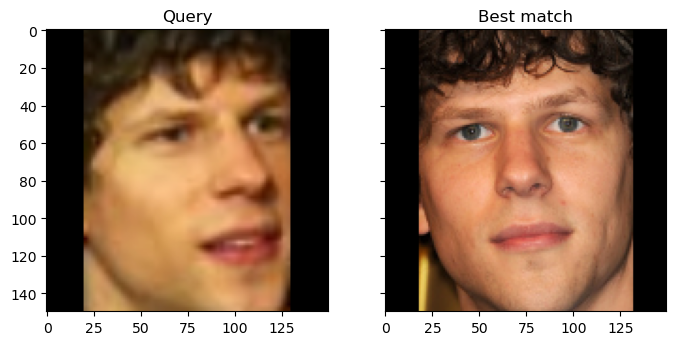

In [157]:
pca1 = PCAFeatureExtractor(5, train_X)
#THIqueryS IS A TEST FOR THE PCA
weights = pca1.transform(train_X)
# Test on out-of-sample image of existing class
query = test_X[11]

print(query.shape)
query_weight = pca1.transform(query)
euclidean_distance = np.linalg.norm(weights - query_weight, axis=1)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (train_y[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query, cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(train_X[best_match], cmap="gray")
axes[1].set_title("Best match")
plt.show()

## choosing the right number of components

This could be done either by testing different values and choosing the one that leads to greater accuracy or by analyzing the singular values. Each singular value indicates how much information does the corresponding eigenvector contain. From the following plot we notice that after the 5th vector the ammount of information start to decrease less rapidly so a good number of components would probably be around 5. This could be a good trade-off between number of features and accuracy.

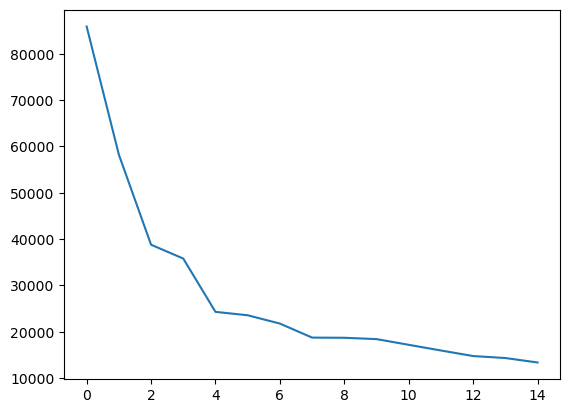

In [181]:
#plotting first 15 singular values
plt.plot(range(15), pca1.singular[:15])

### 1.2.1. Eigenface Plots
...

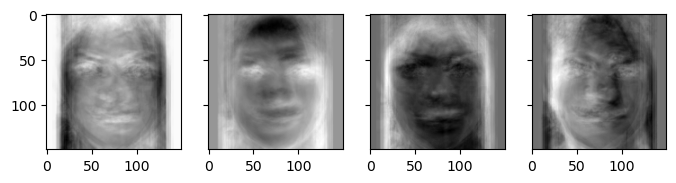

In [169]:
fig, axes = plt.subplots(1,4,sharex=True,sharey=True,figsize=(8,10))
for i in range(4):
    axes[i].imshow(pca1.eigenfaces[i].real.reshape((150,150)), cmap="gray")
plt.show()

We can now see how we are able to reconstruct a face using the features and a certain number of eigenfaces. We notice that the face start to be distinguishable already after a small number of eigenfaces, and after a certain number adding another eigenface does not add a lot to the picture. This is because the first egienfaces are the one that "contain" more information while the last ones encapsulate small features about the image. This is the reason why we can choose to only use a certain number of eigenfaces as features to make the model less complex but still pretty accurate.

Text(0.5, 1.0, 'using 80 eigenfaces')

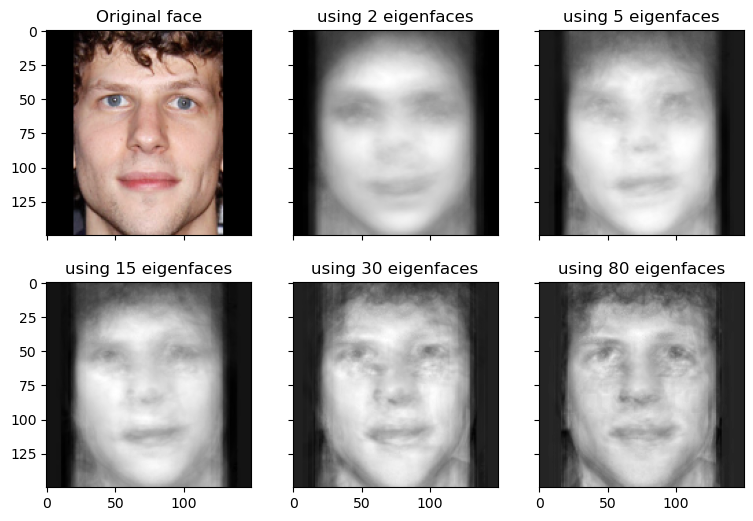

In [161]:
values = [2, 5, 15, 30, 80]
plotPCA = [PCAFeatureExtractor(i, train_X) for i in values]
query = test_X[8]
fig, axes = plt.subplots(2,3,sharex=True,sharey=True,figsize=(9,6))
axes[0][0].imshow(query, cmap="gray")
axes[0][0].set_title("Original face")
features = [plotPCA[i].transform(query) for i in range(5)]
inverse = [plotPCA[i].inverse_transform(features[i]) for i in range(5)]
axes[0][1].imshow(inverse[0].reshape((150,150)), cmap="gray")
axes[0][1].set_title("using 2 eigenfaces")
axes[0][2].imshow(inverse[1].reshape((150,150)), cmap="gray")
axes[0][2].set_title("using 5 eigenfaces")
axes[1][0].imshow(inverse[2].reshape((150,150)), cmap="gray")
axes[1][0].set_title("using 15 eigenfaces")
axes[1][1].imshow(inverse[3].reshape((150,150)), cmap="gray")
axes[1][1].set_title("using 30 eigenfaces")
axes[1][2].imshow(inverse[4].reshape((150,150)), cmap="gray")
axes[1][2].set_title("using 80 eigenfaces")

### 1.2.2. Feature Space Plots
...

In [ ]:
diff = facematrix - pca1.mean - np.dot(pca1.transform(facematrix)[:, :2], pca1.eigenfaces[:2])

# plot the difference
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(diff[:, 0], diff[:, 1], alpha=0.5)

In [ ]:
diff = facematrix - pca1.mean - np.dot(pca1.transform(facematrix)[:, :2], pca1.eigenfaces[:2])
fig, axes = plt.subplots(figsize=(10, 10))
axes.set_xlim([np.min(diff[:, 0])-50, np.max(diff[:, 0])+50])
axes.set_ylim([np.min(diff[:, 1])-50, np.max(diff[:, 1])+50])
axes.set_xticks([])
axes.set_yticks([])

for i in range(len(facematrix)):
    img = facematrix[i].reshape(train_X.shape[1], train_X.shape[2])
    x = diff[i, 0]
    y = diff[i, 1]
    axes.imshow(img, extent=[x-20, x+20, y-20, y+20], cmap='gray', alpha=0.8)

### 1.2.3. Discussion

#### PCA
PCA (Principal Component Analysis) is a technique widely used in Machine Learning to reduce the dimensionality of a dataset while retaining as much informations as possible. Do to that it transform the original dataset into a new coordinat system in which each dimension is a linear combination of the original variables. PCA requires the dataset to be centered (the mean has to be 0). After that we can compute the covariance matrix of the data and use that to extract the eigenvalues and eigenvectors. Eigenvectors reppresents directions in which the data varies the most, in the particular case of face detection these vectors are also called eigenfaces. By projecting a datapoint onto these eigenvectors we get features that we can use to train a model. The eigenvalues express how much variance is contained in each eigenvector. The eigenvectors with more variance are also the ones that contains the more informations and so the one we should use to extract important features in face recognition. This is why we usually decide to only use the first n eigenvectors (choosing n is usually a tradeoff between complexity and accuracy of the model). 

#### SVD
In our case we found the computation of the eigenvectors to be really slow and inefficent so we decide to use SVD to reach an equivalent result. SVD (Singular Value Decomposition) is another technique used to reduce dimensionality of a dataset. This technique takes a matrix A and decompose it in three matrixes U,S and V. S contains the singular values which can be seen as the eigenvalues and represent the importance of each principal component. U and V are the left and right singular vectors which can be used to transform the data into the new coordinate system (as the eigenvectors). When the matrix is centered the eigenvectors and the columns of U are equivalent.

# 2. Evaluation Metrics
## 2.0. Example: Accuracy
As example metric we take the accuracy. Informally, accuracy is the proportion of correct predictions over the total amount of predictions. It is used a lot in classification but it certainly has its disadvantages...

In [20]:
from sklearn.metrics import accuracy_score

# 3. Classifiers

Now that we have created two different feature extraction models, its time to put these to the test! Below, we will create ***NUMBER OF CLASSIFIERS*** models to classify the images. We have tried multiple different models, for each type of classifier, and these will be mentioned in their respective sections. 

## 3.1 Support Vector Machine

In [109]:
class SVM:

    def __init__(self, ensemble=False):

        if not ensemble:
            self.model = svm.SVC(probability=True, kernel="rbf")
        
        else:
            models = list()
            models.append(('svm0', svm.SVC(probability=True, kernel="rbf")))
            models.append(('svm1', svm.SVC(probability=True, kernel='poly', degree=2)))
            models.append(('svm2', svm.SVC(probability=True, kernel='poly', degree=3)))
            models.append(('svm3', svm.SVC(probability=True, kernel='linear')))
            models.append(('svm4', svm.SVC(probability=True, kernel='poly', degree=4)))
            models.append(('svm5', svm.NuSVC(probability=True, nu=0.7, kernel='rbf')))
            models.append(('svm6', svm.NuSVC(probability=True, nu=0.5, kernel='rbf')))
            self.model = sklearn.ensemble.VotingClassifier(estimators=models, voting='soft')

    def fit(self, X, y):
        
        
        
        return self.model.fit(X, y) 
        
    def predict(self, X, probs=False):

        
        return self.model.predict_proba(X) if probs else self.model.predict(X)
    
    def __call__(self, X, probs=False):
        return self.predict(X, probs)

## 3.2. Deep Learning

Although we have very small amount of samples at hand, we wanted to try some deep learning solutions. Deep learning is known for its black-box nature, and its robustness generally depends on the amount of data that is fed into the model. There are some methods to counteract the lack of data at hand, which we utilize. One of the caveats (and also possibly advantages) is the immensly big solution space that it has. This is a caveat in our case, since finding the right hyperparameters takes many training iterations, many different models etc. There are some helpful API that help in solving this issue (KerasTuner from Keras, GridSearchCV from sklearn), which we have tried but in the end found to be inefficient (intuition is also a viable option). Below, more of these will be mentioned in depth.

### 3.2.1 Model Creation

For this classifier type, we have created two models. One of them is a compact ANN, built to be used with extracted PCA features. The other is a transfer learning solution, built to be used with the faces themselves (without prior feature extraction).

#### 3.2.1.1 Compact DL Model

Below, the first model can be observed. There are several things to consider while building a model, and these are related with the amount of data we have as well.

Important considirations that went into building this model:
>* Overfitting and Complexity: Because of the scarcity of data, any DL model that we will attempt to build is prone to overfitting (the phenomenon of the model losing generalization because it favors training data). Hence, we want a model that is not too simple, otherwise the model cannot be general, and test accuracy will fail. However, also because of the scarcity of data, we cannot attempt to build an extremly complex model, since this would result in the model not being able to extract patterns in our data, resulting in abysmal accuracy. Hence; it is a slippery slope, and there needs to be balance, both in terms of the number of units used and the amount of layers utilized.
>* Regularization: Following this discussion on overfitting, we can utilize something called regularization to get in the way of overfitting, and create a more general model. There are many ways to implement regularization, with the most popular one (and the one used in this model) being the Dopout layer. This layer randomly selects _p_ percentage of the data inputted into the layer and drops them (= 0). This helps in 2 ways: the model becomes less dependent on training data, and layers capture more distinct features.
>* Activation Function(s): Since we are doing a (multi-class) classification model, the last layer of the network has to be a softmax (although not the case here, it can also be a single unit with sigmoid if the problem at hand is a binary classification problem). The softmax function outputs probabilities for each class, and the whichever class has the maximum probability is the final prediction. For the other layers, we use an activation called Rectified Linear Unit (ReLU). ReLU is popular and practical since its gradient computation is easy, and the model can converge faster when its used. It also does not enable all neurons (if _v_ < 0, _relu(v)_ = 0), hence forward pass is also quicker. We have tried other activation functions (tanh and sigmoid), but they were sub-optimal. For future improvements, advanced activation functions such as LeakyReLU can be utilized.

In the end, we use a neural network structure that has 4 layers, with the last layer being where the classification takes place.

In [155]:
def create_compact_model(num_classes, input_shape):
    
    inputs = keras.Input(shape=input_shape)
    x = layers.LayerNormalization(axis=-1)(inputs)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    
    outputs =layers.Dense(units, activation=activation)(x)
    
    
    return {"model": keras.Model(inputs, outputs), 
            "num_classes": num_classes, 
            "input_shape": input_shape}

#### 3.2.1.2 Transfer Learning (with an option to fine-tune) using Xception

Below, we create our second model. With such a small dataset, trying transfer learning was a no-brainer. For this model, we also added the option to fine-tune the base model. Now lets discuss the thought process that went into this model.

Important explanations for techniques that were used, and considerations that went into building this model:
>* Transfer Learning: For some problems, similar to our case, it is more practical (and desirable, and accurate) to use an already existing model, that was trained on hefty datasets. These pre-trained models are most common in CV and NLP (famously BERT) applications. Transfer learning is one of the two approaches to using these pre-trained models. It describes freezing some or all layers of a pre-trained network, taking the top layer (which is the output layer) off and putting a smaller, untrained model on top. After that, training is done ONLY on the smaller model that has been initialized on top of the base network. This process can also be, in simplified terms, described as feature extraction. In this case, the extractor is not PCA or SIFT, but a pretrained DL model. With those features we train a smaller model, and reach an accurate model. In our case this approach was more succesful compared to fine-tuning.
>* Fine-Tuning: Similar to transfer learning, a pre-trained model is used for fine-tuning. In the case of fine-tuning, we train the base model as well. Again we take the top layer off, and put our own smaller model (or a single empty layer), but some/all layers of the base model are also trainable. However; a yet unmentioned hyperparameters, learning rate and epoch, comes in to consideration. To find an optimal solution and to avoid overfitting, fine-tuning is done with a very small learning rate (e.g. 1e-5) and epoch (e.g. 3-7). In our case, transfer learning was more succesful, and fine-tuning overfit the data pretty quickly (or did not learn accurate general patterns).
>* Overfitting, complexity and similar considerations to the previous model: Similar considerations went into developing the rest of the model, we use dropout to reduce chances of overfitting, use softmax for classification and we try to keep the model mildly complex so that our data's distinctions are recognized by the model.
>* Small snippet of data augmentation: The bulk of data augmentation will be mentioned in the DL framework that we have developed, but here we do two simple steps to generalize our training data: random contrast and gaussian noise. Additionally, we mentioned dropout, and how its a regularization method to create a more general and accurate model. GaussianNoise is another layer that can be used for a similar purpose as well.
 
We utilize Xception as our base model. Xception is trained on the ImageNet database, and is a lighter model compared to other options (e.g. VGG, which we tried and found to be sub-optimal). The features extracted from Xception are then average pooled and inputted into a 2 layer ANN.

In [80]:
# TRANSFER LEARNING - Xception, VGG16


def create_transfer_learning_model(num_classes, input_shape, fine_tune=False, augment_data=False):

    base_model = keras.applications.Xception(
    weights='imagenet',  
    input_shape=input_shape,
    include_top=False)

    base_model.trainable = fine_tune
    
    
    inputs = keras.Input(shape=input_shape)

    if augment_data:
        
        x = layers.RandomContrast(0.2)(inputs)
        x = layers.GaussianNoise(0.2)(x)
        
    else:
        x = inputs
        
    
    x = keras.applications.xception.preprocess_input(x)
    x = base_model(x, training=fine_tune)
    x = layers.GlobalAveragePooling2D()(x)
    
    if not fine_tune:
        x = layers.Dropout(0.1)(x)
        x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    
    outputs =layers.Dense(units, activation=activation)(x)
    
    
    return {"model": keras.Model(inputs, outputs), 
            "num_classes": num_classes, 
            "input_shape": input_shape}

### 3.2.2 Framework, Data Augmentation, Optimizers


#### Data Augmentation

To counteract the scarcity of our training samples, we use data augmentation. Data augmentation is a technique to increase training data samples by different augmentation techniques, such as rotations, shifts, flips and random brightness values. This is essential to our training, and gets in the way of the model overfitting. It helps the model learn general features, independent of rotation, flips etc. For this, we use the Keras implementation of ImageDataGenerator. Using the flow funtion of said class, we obtain a data generator that returns randomly augmented training images. Below, an example of an augmented image is given. 

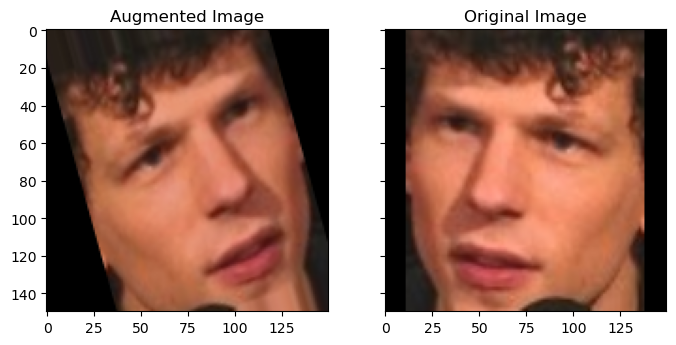

In [203]:
datagen = keras.preprocessing.image.ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.1,
                height_shift_range=0.1,
                shear_range=0.1,
                zoom_range=0.1,
                horizontal_flip=True,
                brightness_range=[0.9, 1.1],
                fill_mode='nearest',
                dtype="uint8")
            
iterable = datagen.flow(x=train_X, batch_size=21, shuffle=False)  

x = next(iterable)[20]

fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(x, cmap="gray")
axes[0].set_title("Augmented Image")
axes[1].imshow(train_X[20], cmap="gray")
axes[1].set_title("Original Image")
plt.show()



Below, the deep learning model framework that we have developed can be observed. 

General remarks:
>* Categorical labels: The labels provided to us have 3 different values (0, 1, 2); however, the loss function used (and also since the output of the networks are (,3)) requires the labels to be one hot encoded. What this means is, if the label is class 2 for example, its one hot encoded represantation becomes a vector like [0, 0, 1]. There is a loss function that accepts numerical labels, but we decided to stick with categorical labels.
>* Custom Generator: This is implemented so that the feature extractors also use augmented images. 
>* Some failures: We tried early stopping, which if it worked in a successful manner wouldve been good to utilize. However, we decided to not use it in the end since our training time is not that long (we dont have a lot of data, and our models are not that complex). So early stopping was not that useful.


#### Optimizers

We have tried three different optimizers for this assignment, these are Stochastic Gradient Descent (SGD), Adam, and a new implementation of Adam called AdamW. Adam is the most popular choice in literature, because of its efficiency in converging to a solution. SGD is also another, simpler implementation of an optimizer, it finds a more optimal solution compared to Adam, but is slower and at times less accurate (because Adam has built in regularization parameters). AdamW is a different implementation of Adam that implements weight decay differently, and is popular in NLP applications. We wanted to try these three optimizers because of their popularity, and found that Adam gave us the best results for our problem.

#### Training and Prediction

For both training and prediction we use the built in _fit()_ and _predict_ methods of the Keras model respectively. 



In [201]:
class CustomGenerator(keras.utils.Sequence):
    
    def __init__(self, iterable, fe):
        self.iterable = iterable
        self.fe = fe
        
    def __len__(self):
        return len(self.iterable)

    def __getitem__(self, idx):
        x, y = next(self.iterable)
        return self.fe(x), y
    


class DeepLearningModel:
    
    def __init__(self, model, num_classes, input_shape, feature_extractor=None):        
        self.model = model
        self.num_classes = num_classes
        self.input_shape = input_shape
        self.feature_extractor = feature_extractor
    
    def fit(self, X, y, epoch=10, lr=1e-3, batch_size=4, augment_data=False, opt="adam", val_ds=None):
        
        y_OHE = keras.utils.to_categorical(y, num_classes = self.num_classes)
        
        if augment_data:
            
            datagen = keras.preprocessing.image.ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.05,
                height_shift_range=0.05,
                shear_range=0.05,
                zoom_range=0.05,
                horizontal_flip=True,
                brightness_range=[0.9, 1.1],
                fill_mode='nearest',
                dtype="uint8")
            
            iterable = datagen.flow(x=X, y=y_OHE, batch_size=batch_size, shuffle=True)            
            kwargs = {"x": iterable if self.feature_extractor is None else CustomGenerator(iterable, self.feature_extractor)}
            
        else:
            kwargs = {"x": X if self.feature_extractor is None else self.feature_extractor(X), "y": y_OHE, "batch_size": batch_size, "shuffle":True}
    
        
        if opt == "adam":
            optimizer=keras.optimizers.Adam(lr=lr)
            
        if opt == "sgd":
            optimizer=keras.optimizers.SGD(lr=lr, momentum = 0.9)
            
        if opt == "adamw":
            optimizer = keras.optimizers.experimental.AdamW(learning_rate=lr, weight_decay=5e-3)

        self.model.compile( optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    
        return self.model.fit(**kwargs, epochs=epoch, validation_data=val_ds,)
    
        
    def predict(self, X, probs=False):
        
        if self.feature_extractor is None:
            pred = self.model.predict(X)
        else:
            feats = self.feature_extractor(X)
            pred = self.model.predict(feats)
            
        return pred if probs else np.argmax(pred, axis=-1)
    

    def __call__(self, X, probs=False):
        return self.predict(X, probs)

## 3.3 Random Forest

In [125]:
class RandomForest:
    
    def __init__(self, n_estimators=100, max_depth=2):

        self.model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=0)

    
    def fit(self, X, y):
        
        return self.model.fit(X, y)
        
    def predict(self, X):

        
        return self.model.predict(X)
    
    def __call__(self, X):
        return self.predict(X)

## 3.4 Ensemble Model

Here, we create a simple framework for a weighted ensemble model. It uses pre-trained classifier pipelines. Each pipelines predicted provabilites are obtained and a weighted sum is obtained. Afterwards the maximum class is chosen as the predicted class. 

In [126]:
class EnsembleModel:
    
    def __init__(self, trained_models, weights):

        self.models = trained_models
        self.weights = weights
        
    def predict(self, X):
        
        preds = None
        
        for m, w in zip(self.models, self.weights):
            
            if preds is None:
                preds = w * m(X, True)
                
        
            else:
                preds += w * m(X, True)

        
        return np.argmax(preds, axis=-1)
    
    def __call__(self, X):
        return self.predict(X)

# 4. Experiments


## 4.1 Experiments with SVM

The experimentation with SVM is simple. We choose 20 principle components for PCA, and input the features into the model. Then we create the pipeline lambda function.

In [174]:
### USING SVM w/ PCA

k = 20

aX, ay = train_X, train_y

feature_extractor = PCAFeatureExtractor(k, train_X)
classifier = SVM(False)

val_ds = (feature_extractor(val_X), val_y)


classifier.fit(feature_extractor(aX), ay)

svm_pipeline = lambda X, p=False: classifier(feature_extractor(X), p)

## 4.2 Experiements with Deep Learning Models

The experimentation for DL models are a bit more complex, with more consideration in place. Again, overfitting and generalization is one of the biggest considerations in how we choose the following hyperparameters.

>* Epochs: A single epoch is a single fit of the entire dataset onto the model. A single run on the training dataset is not enough, since the model will not be able to capture patters that quickly; however, increasing this value greatly (to hundreds, thousands) is counter-intuitive. This will cause the model to specifically consider the training data, and will get in the way of generalization. We have tried values between 10-50, for transfer learning 30 epochs is enough, for the PCA model we have found 50 to be the best. 
>* Learning Rate: The learning rate is the parameter that defines the speed in which the network weights are learned. It is another tricky parameter: if its too big the model will overshoot the optimal point and oscillate between sub-optimal points, if its too small the model will not be able to reach the optimal point. Again, it has to have some balance, fast but steady. Below a simple reprasentation of how learning rate behaves can be observed in a 2D space. For our purposes, values between $10^{-3}$ and $10^{-2}$ gave accurate results.

 <div style="text-align:center"><img src="https://www.jeremyjordan.me/content/images/2018/02/Screen-Shot-2018-02-24-at-11.47.09-AM.png" width="40%" height="40%"></div>

>* Batch Size: Batch size is another important parameter when considering generalization. A model trained with a large batch size will become a more general model. However, we do risk the model being too general (i.e. not learning patterns in training data). So again, there has to be a balanced option. In our case, 32 gave us the best results. 

There are many more hyperparameters that we could've considered (most of them are optimizer specific, such as momentum (for SGD), beta1/2 and epsilon (Adam) and finally weight decay). However, these parameters have common values among literature, and putting these parameters into consideration as well would increase the complexity of our parameter space greatly. Trying different values for the previously mentioned hyperparameters were enough to find an accurate model.

In [ ]:
# ### PCA - DEEP LEARNING
# k = 30
# feature_extractor = PCAFeatureExtractor(k, train_X)
# # # classifier = RandomClassificationModel()

# kwargs = create_compact_model(num_classes=3, input_shape=k) # we do [1:] to NOT consider the batch size in the model
# print(kwargs["model"].summary())
# classifier = DeepLearningModel(**kwargs, feature_extractor=feature_extractor)

# val_ds = (feature_extractor(val_X), val_y)

# # train the model on the features
# classifier.fit(train_X, train_y, epoch=50, lr=5e-3, batch_size=32, augment_data=True, val_ds=val_ds, opt="adam")

# # # model/final pipeline
# pca_dl_pipeline = lambda X, p=False: classifier(X, p)

In [199]:
### USING ONLY THE PICTURES - TRANSFER LEARNING

kwargs = create_transfer_learning_model(num_classes=3, input_shape=train_X.shape[1:], augment_data=True) # we do [1:] to NOT consider the batch size in the model
print(kwargs["model"].summary())
classifier = DeepLearningModel(**kwargs)

val_ds = (val_X, val_y)

# train the model on the features
classifier.fit(train_X, train_y, epoch=30, lr=2e-3, batch_size=32, augment_data=True, val_ds=val_ds, opt="adam")

# # model/final pipeline
tf_dl_pipeline = lambda X, p=False: classifier(X, p)

Model: "model_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_70 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 random_contrast_29 (RandomC  (None, 150, 150, 3)      0         
 ontrast)                                                        
                                                                 
 gaussian_noise_29 (Gaussian  (None, 150, 150, 3)      0         
 Noise)                                                          
                                                                 
 tf.math.truediv_29 (TFOpLam  (None, 150, 150, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_29 (TFOpLa  (None, 150, 150, 3)      0         
 mbda)                                                    

In [172]:
em = EnsembleModel([tf_dl_pipeline, svm_pipeline], weights=[0.6, 0.4])

# 5. Publishing best results

In [175]:
# evaluate performance of the model on the training set
train_y_star = em(train_X)
print(train_y_star)

print(f"The performance on the training set is {accuracy_score(train_y, train_y_star):.2f}. This however, does not tell us much about the actual performance (generalisability).")

# predict the labels for the test set 
test_y_star = tf_dl_pipeline(test_X)

submission = test.copy().drop('img', axis = 1)
submission['class'] = test_y_star

submission

submission.to_csv('submission.csv')

[2 2 0 2 0 1 2 1 2 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 0 2 1 2 2 2 2 0 2 1 1 0
 2 2 2 2 0 0 2 2 1 2 0 1 1 2 2 1 1 1 0 2 2 0 0 1 2 1 0 2 0 1 2 1 1 1 0 1 1
 2 2 0 2 2 0]
The performance on the training set is 0.97. This however, does not tell us much about the actual performance (generalisability).


# 6. Discussion
...

In summary we contributed the following: 
* 
